In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import cv2
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchkbnufft as tkbn
import utils
import visualisation

In [2]:
# Config
#debug = False
#animate = True
dtype = torch.float32
complex_dtype = torch.complex64
numpoints = 6
#eps = 1e-12
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device:', device)
#matplotlib.use("Agg") if animate else None
torch.autograd.set_detect_anomaly(True)
#mode = 1

device: cpu


In [3]:
def sample_movements(n_movements, ndims, angles_std=5.0, trans_std=10.0, dtype=torch.float32, device=None):
    """Sample movement affine transforms."""
    affines = []
    angles = angles_std * torch.randn((n_movements+1,), dtype=dtype, device=device)
    trans = trans_std * torch.randn((n_movements+1,2), dtype=dtype, device=device)
    for i in range(n_movements+1):
        ang = angles[i]
        t = trans[i,:]
        A = torch.eye(ndims+1).to(device)
        R = utils.rotation_matrix_2d(ang, device=device)
        A[:ndims,:ndims] = R.to(device)
        A[:ndims,ndims] = t.to(device)
        affines.append(A)
    return affines, angles, trans

In [4]:
def gen_masks(n_movements, locs, grid_size, use_torch=True):
    """Generate k-space masks."""
    masks = []
    if n_movements > 0:
        mask = torch.arange(0,locs[0],dtype=torch.long,device=device)
        masks.append(mask)
        for i in range(1,n_movements):
            mask = torch.arange(locs[i-1],locs[i],dtype=torch.long,device=device)
            masks.append(mask)
        mask = torch.arange(locs[-1],grid_size[0],dtype=torch.long,device=device)
        masks.append(mask)
    else:
        masks.append(torch.arange(0,grid_size[0],dtype=torch.long,device=device))
    return masks

In [5]:
def gen_ktraj(nlines, klen, kdepth=None, use_torch=True, device=None):
    """Generate kx, ky, kz."""
    if use_torch:
        if kdepth is None:
            kx = torch.linspace(-np.pi, np.pi, klen)
            ky = torch.linspace(-np.pi, np.pi, nlines)
            kx, ky = torch.meshgrid(kx, ky)
            kx = kx.T.to(device)
            ky = ky.T.to(device)
            return kx, ky
        else:
            kx = torch.linspace(-np.pi, np.pi, klen)
            ky = torch.linspace(-np.pi, np.pi, nlines)
            kz = torch.linspace(-np.pi, np.pi, kdepth)
            kx, ky, kz = torch.meshgrid(kx, ky, kz)
            kx = kx.permute(1,0,2).to(device)
            ky = ky.permute(1,0,2).to(device)
            kz = kz.permute(1,0,2).to(device)
            return kx, ky, kz
    else:
        kx = np.linspace(-np.pi, np.pi, klen)
        ky = np.linspace(-np.pi, np.pi, nlines)
        kx, ky = np.meshgrid(kx, ky)
        return kx, ky

In [6]:
def build_kspace(image_shape, sampling_rate=1.0, device=None):
    """Construct the k-space trajectory."""
    ndims = len(image_shape)
    if ndims == 2:
        kr = int(image_shape[0] * sampling_rate)
        kc = int(image_shape[1] * sampling_rate)
        grid_size = (kr, kc)
        kx, ky = gen_ktraj(kr, kc, device=device)
        kz = None
    if ndims == 3:
        kr = int(image_shape[0] * sampling_rate)
        kc = int(image_shape[1] * sampling_rate)
        kd = int(image_shape[2] * sampling_rate)
        grid_size = (kr, kc, kd)
        kx, ky, kz = gen_ktraj(kr, kc, kd, device=device)
    return kx, ky, kz, grid_size

In [7]:
def apply_rotation(angles, kx, ky, kz=None, ndims=None, masks=None, dtype=torch.float32, device=None):
    """Apply rotation to k-space trajectory."""
    if ndims == 2:
        kx_new = torch.zeros_like(kx, device=device)
        ky_new = torch.zeros_like(ky, device=device)
        kz_new = None
        for i in range(len(masks)):
            ang = torch.deg2rad(angles[i])
            kyi = torch.cos(ang)*ky - torch.sin(ang)*kx
            kxi = torch.sin(ang)*ky + torch.cos(ang)*kx
            kx_new[masks[i],...] = kxi[masks[i],...]
            ky_new[masks[i],...] = kyi[masks[i],...]
    if ndims == 3:
        kx_new = torch.zeros_like(kx, device=device)
        ky_new = torch.zeros_like(ky, device=device)
        kz_new = torch.zeros_like(kz, device=device)
        for i in range(len(masks)):
            ang = torch.deg2rad(angles[i])
            ax, ay, az = ang[0], ang[1], ang[2]
            cax, sax = torch.cos(ax), torch.sin(ax)
            cay, say = torch.cos(ay), torch.sin(ay)
            caz, saz = torch.cos(az), torch.sin(az)

            kyi = (cax*cay)*ky + (cax*say*saz - sax*caz)*kx + (cax*say*caz + sax*saz)*kz
            kxi = (sax*cay)*ky + (sax*say*saz + cax*caz)*kx + (sax*say*caz - cax*saz)*kz
            kzi = (-say)*ky + (cay*saz)*kx + (cay*caz)*kz
            kx_new[masks[i],...] = kxi[masks[i],...]
            ky_new[masks[i],...] = kyi[masks[i],...]
            kz_new[masks[i],...] = kzi[masks[i],...]
    return kx_new, ky_new, kz_new

In [8]:
def apply_translation(ts, kdata, kx, ky, kz=None, grid_size=None, ndims=None, masks=None, dtype=torch.float32, device=None):
    """Apply translation as phase shift to k-space."""
    kdata = torch.reshape(kdata, grid_size)
    kdata_new = torch.zeros_like(kdata, device=device)
    for i in range(len(masks)):
        t = ts[i]
        if ndims == 2:
            kdata_i = utils.translate_opt(kdata, torch.stack((ky.flatten(), kx.flatten())), t, device=device)
        if ndims == 3:
            kdata_i = utils.translate_opt(kdata, torch.stack((ky.flatten(), kx.flatten(), kz.flatten())), t, device=device)
        kdata_new.real[masks[i],...] = kdata_i.real[masks[i],...]
        kdata_new.imag[masks[i],...] = kdata_i.imag[masks[i],...]
    kdata = kdata_new.flatten().unsqueeze(0).unsqueeze(0)
    return kdata

In [9]:
def build_nufft(image, im_size, grid_size, numpoints, complex_dtype=torch.complex64, device=None):
    """Init NUFFT objects."""
    nufft_ob = tkbn.KbNufft(
        im_size=im_size,
        grid_size=grid_size,
        numpoints=numpoints,
        ).to(complex_dtype).to(device)
    adjnufft_ob = tkbn.KbNufftAdjoint(
        im_size=im_size,
        grid_size=grid_size,
        numpoints=numpoints,
        ).to(image).to(device)
    return nufft_ob, adjnufft_ob

In [10]:
def apply_nufft(nufft_ob, image, ndims, kx, ky, kz=None, dtype=torch.float32, device=device):
    """Nufft."""
    if ndims == 2:
        return nufft_ob(image, torch.stack((ky.flatten(), kx.flatten()))).to(device)
    if ndims == 3:
        return nufft_ob(image, torch.stack((ky.flatten(), kx.flatten(), kz.flatten()))).to(device)

In [11]:
def apply_adjnufft(adjnufft_ob, kdata, ndims, kx, ky, kz=None, dtype=torch.float32, device=device):
    """Adjnufft."""
    if ndims == 2:
        image_out = adjnufft_ob(kdata, torch.stack((ky.flatten(), kx.flatten())))
    if ndims == 3:
        image_out = adjnufft_ob(kdata, torch.stack((ky.flatten(), kx.flatten(), kz.flatten())))
    return utils.normalise_image(image_out).to(dtype)

In [12]:
def gen_movement(image, ndims, im_size,
                 kx, ky, kz=None, grid_size=None,
                 n_movements=None, angles_std=None, trans_std=None,
                 dtype=torch.float32, device=None): #, debug=False

    # Sample affines
    affines, angles, ts = sample_movements(n_movements, ndims, angles_std, trans_std, device=device)

    # Generate k-space masks
    locs, _ = torch.sort(torch.randperm(grid_size[0])[:n_movements])
    masks = gen_masks(n_movements, locs, grid_size)

    # Apply rotation component
    kx_new, ky_new, kz_new = apply_rotation(angles, kx, ky, kz, ndims, masks)

    # Fix k-space centre
    if False:
        mid = kx_new.shape[0]//2
        b = int(kx_new.shape[0] * 3/100.0)
        kx_new[mid-b:mid+b,:] = kx[mid-b:mid+b,:]
        ky_new[mid-b:mid+b,:] = ky[mid-b:mid+b,:]

    # Plot ktraj
    #if debug:
    #    visualisation.plot_ktraj(kx_new, ky_new, kz_new)
    #    visualisation.plot_ktraj_image(kx_new, ky_new, kz_new)

    # create NUFFT objects, use 'ortho' for orthogonal FFTs
    nufft_ob, adjnufft_ob = build_nufft(image, im_size, grid_size, numpoints, device=device)

    # Calculate k-space data
    kdata = apply_nufft(nufft_ob, image, ndims, kx, ky, kz, dtype=dtype, device=device)

    # Apply translational component
    kdata = apply_translation(ts, kdata, kx_new, ky_new, kz_new, grid_size, ndims, masks, dtype=dtype, device=device)

    # Plot the k-space data on log-scale
    #if debug:
    #    kdata_numpy = np.reshape(kdata.detach().cpu().numpy(), grid_size)
    #    visualisation.plot_kdata(kdata_numpy, ndims)

    # Output image
    image_out = apply_adjnufft(adjnufft_ob, kdata, ndims, kx_new, ky_new, kz_new, dtype=dtype, device=device)
    return image_out, kdata, kx_new, ky_new, kz_new, masks

In [13]:
# Load image
#image = shepp_logan_phantom().astype(np.complex)
#image = utils.load_png('./data/sample_2d.png').astype(np.complex)
#image = utils.load_nii_image('./data/sample_3d.nii.gz')
#image = zoom(image, 0.3).astype(np.complex)
#ndims = len(image.shape)
#im_size = image.shape
#print(im_size)

In [14]:
import sys
sys.path.append("../")
import pydicom
import random

data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

image = image.astype(np.complex)
ndims = len(image.shape)
im_size = image.shape
print(im_size)

(320, 320)


C:\Users\simon\AppData\Local\Temp\ipykernel_34916\2780956123.py:15: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = image.astype(np.complex)


In [15]:
image.dtype

dtype('complex128')

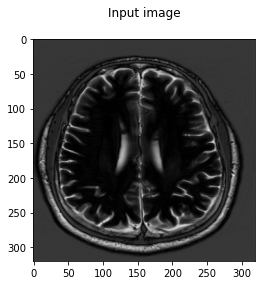

In [16]:
# Visualise
fig = plt.figure()
plt.imshow(np.abs(image), cmap='gray')
plt.suptitle('Input image')
plt.tight_layout()

In [17]:
# Convert image to tensor and unsqueeze coil and batch dimension
image = torch.tensor(image).to(complex_dtype).unsqueeze(0).unsqueeze(0).to(device)

In [18]:
# Create a k-space trajectory
kx_init, ky_init, kz_init, grid_size = build_kspace(im_size, sampling_rate=1.0, device=device)

C:\Users\simon\anaconda3\envs\drs2\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\Users\builder\tkoch\workspace\pytorch\pytorch_1647970138273\work\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [19]:
# Movements
#n_movements = np.minimum(50, grid_size[0])
n_movements = np.random.randint(1, 50)
angles_std_val = 3.0
trans_std_val = 10.0
print('n_movements:', n_movements)

n_movements: 5


In [20]:
# Generate movement
image_out, kdata_out, kx_out, ky_out, kz_out, masks = gen_movement(image, ndims, im_size,
                                                                    kx_init, ky_init, kz_init, grid_size=grid_size,
                                                                    n_movements=n_movements,
                                                                    angles_std=angles_std_val, trans_std=trans_std_val,
                                                                    dtype=dtype, device=device) #debug=debug

C:\Users\simon\anaconda3\envs\drs2\lib\site-packages\torchkbnufft\_nufft\interp.py:385: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if omega.shape[1] / (num_threads // factor) >= min_kspace_per_fork:
C:\Users\simon\anaconda3\envs\drs2\lib\site-packages\torchkbnufft\_nufft\interp.py:651: UserWarning: __rfloordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


In [21]:
# Show the images
image_np = np.abs(np.squeeze(image.detach().cpu().numpy()))
image_out_np = np.abs(np.squeeze(image_out.detach().cpu().numpy()))
diff = np.abs(image_np - image_out_np)
err = diff.sum() / diff.size

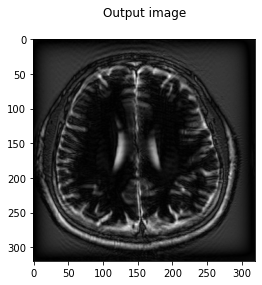

In [22]:
# Visualise
fig = plt.figure()
plt.imshow(image_out_np, cmap='gray')
plt.suptitle('Output image')
plt.tight_layout()

In [23]:
image_out_np.shape
image_out_np.dtype

dtype('float32')

In [24]:
def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    # img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    # img = np.stack([np.real(img), np.imag(img)], 2)
    # img = (img - np.mean(img)) / np.std(img)
    return np.real(img)

In [25]:
def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    # img = np.interp(img, (np.min(img), np.max(img)), (0, 1))
    k = ifftshift(fftn(fftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [26]:
from numpy.fft import fftshift, ifftshift, fftn, ifftn

(-0.5, 319.5, 319.5, -0.5)

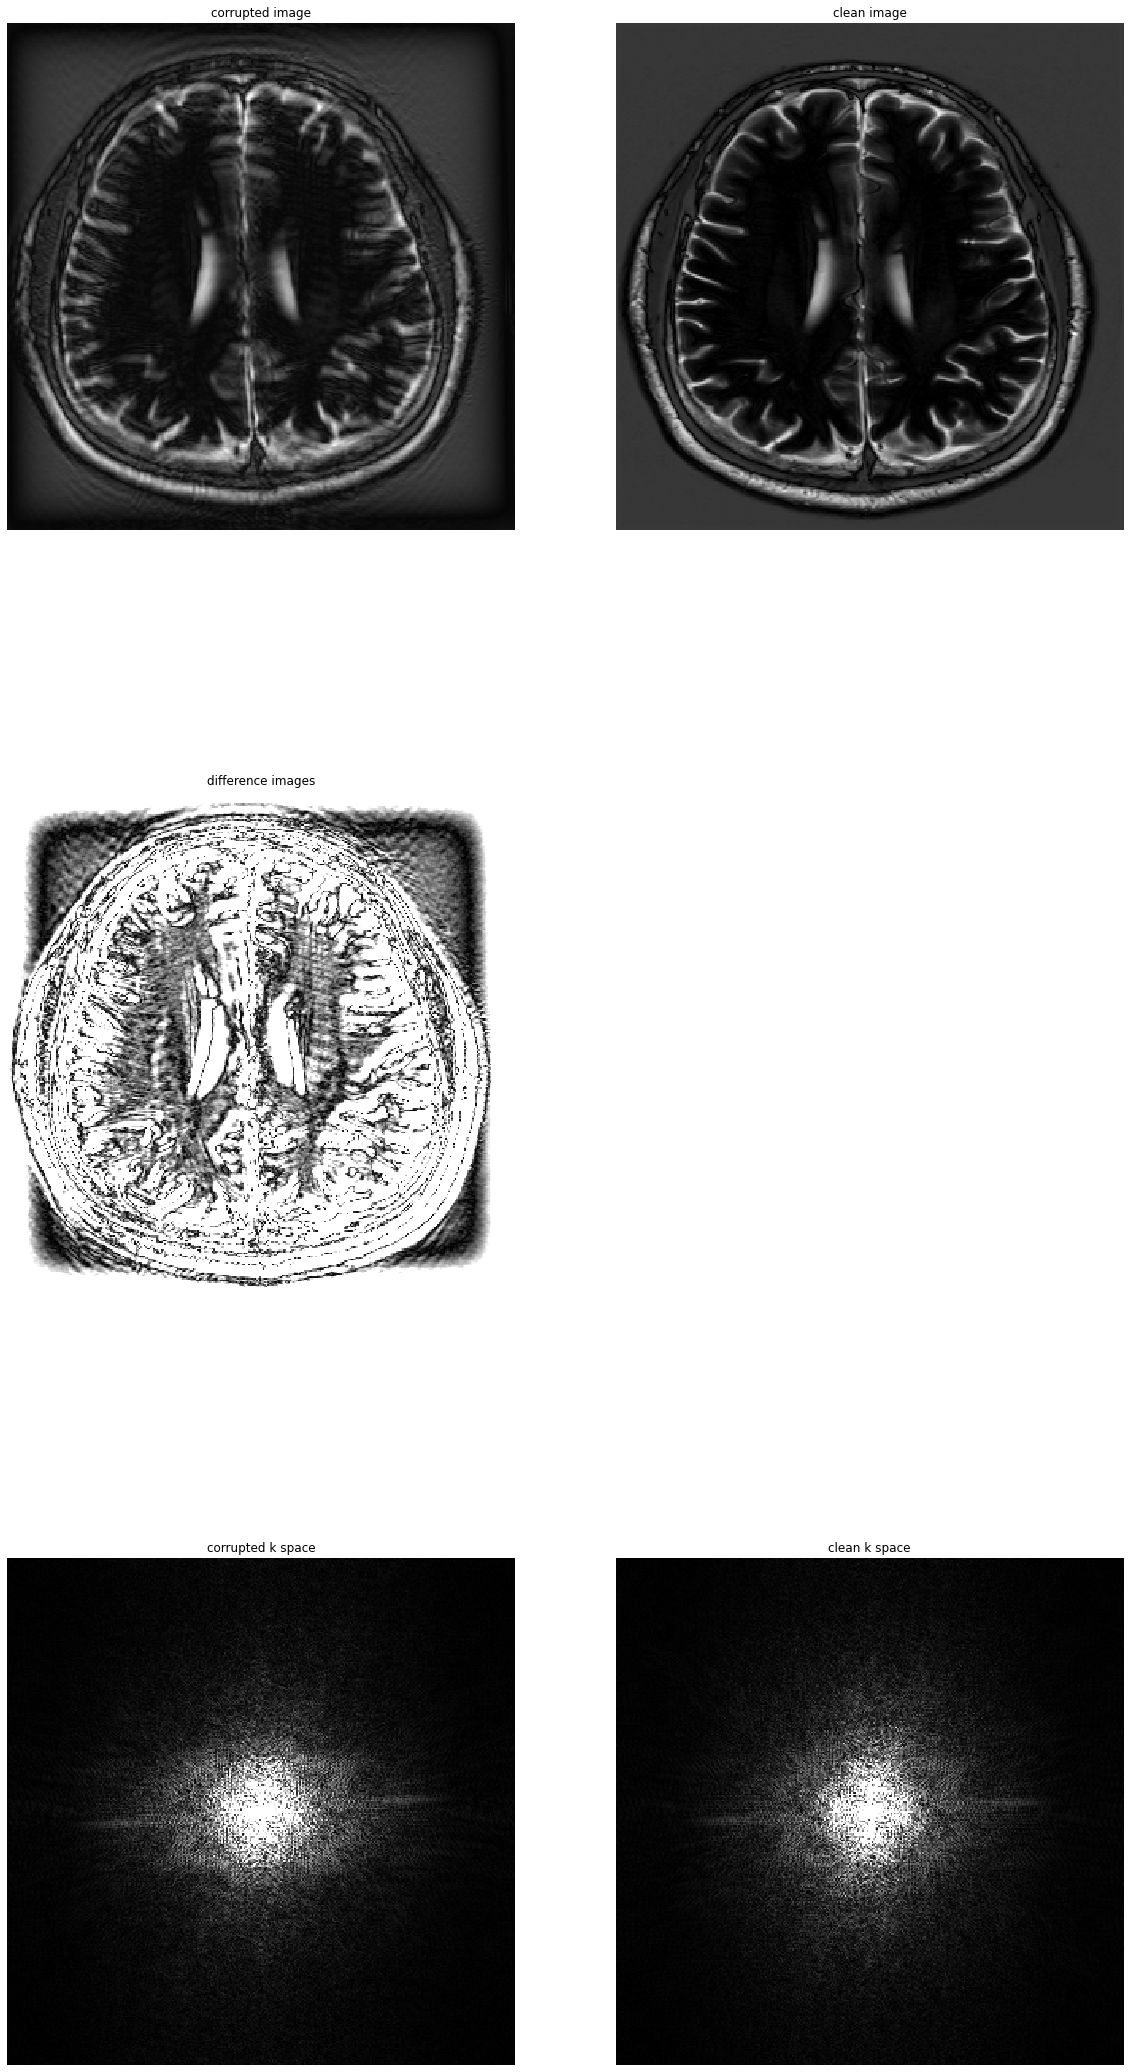

In [27]:
# plotting
hr = image_np
lr = image_out_np

k_lr = np.abs(transform_image_to_kspace(lr))
k_hr = np.abs(transform_image_to_kspace(hr))

k_lr = k_lr / np.max(np.abs(k_lr))
k_hr = k_hr / np.max(np.abs(k_hr))

lr = (lr - np.mean(lr)) / np.std(lr)
hr = (hr - np.mean(hr)) / np.std(hr)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(3, 2, 1)
ax.imshow(lr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("corrupted image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 2)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.set_title("clean image")
ax.axis('off')
ax = fig.add_subplot(3, 2, 3)
ax.imshow(np.abs(lr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.set_title("difference images")
ax.axis('off')
ax = fig.add_subplot(3, 2, 5)
ax.imshow(k_lr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("corrupted k space")
ax.axis('off')
ax = fig.add_subplot(3, 2, 6)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title("clean k space")
ax.axis('off')